In [1]:
# DONE: Import the necessary libraries
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
# from keras.applications.vgg16 import VGG16
from keras import layers
from keras import ops
import cv2
import pandas as pd
import random
import xml.etree.ElementTree as ET
# print(keras.__version__)



2024-10-31 11:10:23.356510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 11:10:23.627366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 11:10:23.734150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 11:10:23.763193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 11:10:23.965028: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# DONE: Make a clean and understandable labels.txt file from annotations.xml 
# Parse the XML file
tree = ET.parse('annotations.xml')  # Replace with your XML file path
root = tree.getroot()

# Dictionary to store the extracted data
data = {}

# Iterate through each image tag
for image in root.findall('image'):
    image_name = image.get('name')  # Get the name attribute (image file name)
    
    # Initialize the entry for this image
    if not '.webp' in image_name:
            
        bboxes= []  # List to hold bounding boxes
            
        
        # Iterate through each box tag inside the image tag
        for box in image.findall('box'):
            # Get Label for each ground truth bounding box
            label = box.get('label')

            # Assuming 1 means tooth and 0 means not tooth
            label = 0  # Change this logic if you need to differentiate labels

            # Extract the top-left and bottom-right coordinates
            top_left_x = box.get('xtl')
            top_left_y = box.get('ytl')
            bottom_right_x = box.get('xbr')
            bottom_right_y = box.get('ybr')

            # Extract rotation angle for each ground truth bounding box
            rotation = box.get('rotation')
            if rotation is None:
                rotation = 0
            
            # Create a string for the bounding box in the required format
            bbox_str = f"{label}, {top_left_x}, {top_left_y}, {bottom_right_x}, {bottom_right_y}, {rotation}\n"
            
            # Append to the list of bounding boxes for this image
            bboxes.append(bbox_str)

    
    
        # Join all bounding boxes as a single string
        base_name, _= os.path.splitext(image_name)
        bboxes_str = " ".join(bboxes)
        # Write the results to labels.txt
        with open(f'./images/{base_name}.txt', 'w') as f:
            # Write to the text file in the format: image_name bounding_boxes
            f.write(f"{bboxes_str}\n")

# Optional: Print the output for verification
# with open('labels.txt', 'r') as f:
#     print(f.read())

In [3]:
# DONE: Load and Preprocess images

BATCH_SIZE = 2
# IMG_WIDTH = 512
IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.AUTOTUNE

def parse_label_file(label_file):
    boxes = []
    with open(label_file, 'r') as file:
        for line in file:
            if line.strip() and not line.strip().endswith(':'):  # Skip empty lines
                values = list(map(float, line.strip().split(',')))
                class_id, x_min, y_min, x_max, y_max, rotation = values
                # FIXME
                # boxes.append([class_id, x_min, y_min, x_max, y_max, rotation])
                boxes.append([class_id, x_min, y_min, x_max, y_max])
    return boxes



# label_file = './images/1.txt'
# image_labels = parse_label_file(label_file)
# # print(image_labels)




def load_data(image_dir, label_dir):
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if not f.endswith('.txt') and not f.endswith('.webp')]

    label_files = [os.path.join(label_dir, f) for f in os.listdir(image_dir) if f.endswith('.txt')]
    

    print(image_files)
    print(len(image_files))
    print(label_files)
    print(len(image_files))

    images = []
    labels = []


    previous_heights = []
    previous_widths = []

    for img_file, lbl_file in zip(image_files, label_files):
        image = tf.io.read_file(img_file)
        image = tf.io.decode_image(image, channels=3)
        # print(image)

        previous_widths.append(image.shape[0])
        previous_heights.append(image.shape[1])

        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = image / 255  # normalize image
        label = parse_label_file(lbl_file)
        images.append(image)
        labels.append(label)
    
    return images, labels, previous_widths, previous_heights



def pad_labels(labels, max_boxes):
    print(max_boxes - tf.shape(labels)[0])
    padded_labels = tf.pad(labels, [[0, max_boxes - tf.shape(labels)[0]], [0, 0]], constant_values=-1)
    return padded_labels






def create_tf_dataset(images, labels, max_boxes):
    def generator():
        for img, lbl in zip(images, labels):
            yield img, pad_labels(lbl, max_boxes)
    
    dataset = tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
        # tf.TensorSpec(shape=(max_boxes, 6), dtype=tf.float32)  # Adjusted to 6 values per box
        tf.TensorSpec(shape=(max_boxes, 5), dtype=tf.float32)  # Adjusted to 6 values per box
    ))
    
    return dataset


# Create the training and test sets
def create_train_test_sets(images, labels, max_boxes, train_split=0.8):
    # Shuffle the data before splitting
    data = list(zip(images, labels))
    random.shuffle(data)
    images, labels = zip(*data)  # Unzipping the data back to images and labels
    
    # Split the data
    train_size = int(train_split * len(images))
    train_images, test_images = images[:train_size], images[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    # Create datasets
    training_set = create_tf_dataset(train_images, train_labels, max_boxes)
    test_set = create_tf_dataset(test_images, test_labels, max_boxes)

    
    return training_set, test_set


# Create TensorFlow dataset
# max_boxes = 32  # Adjust based on your data
# dataset = create_tf_dataset(images, labels, max_boxes)

################################
# Testing and Visualizing codes
# START
# The codes below are just for
# testing purposes 👇👇👇👇👇
################################

# Example of iterating through the dataset
# for image, label in dataset.take(1):
#     mask = tf.not_equal(image, 0)
#     print(image.shape)
#     print(tf.math.count_nonzero(image))
#     print(tf.boolean_mask(image, mask))
#     image = image.numpy()  # Convert the image tensor to numpy
#     plt.imshow(image)
#     plt.axis('off')  # Hide the axis
#     plt.show()

    # print("Image shape:", image.shape)
    # print(image.numpy())
    # print("Label shape:", label.shape)
    # print("Labels:", label.numpy())


# Function to plot multiple images in a row
# def plot_images(images):
#     plt.figure(figsize=(15, 5))  # Set the figure size (width, height)
    
#     for i, image in enumerate(images):
#         image = image.numpy()  # Convert the image tensor to numpy
        
#         plt.subplot(1, len(images), i+1)  # 1 row, len(images) columns
#         plt.imshow(image)
#         plt.axis('off')  # Hide the axis
#         plt.title(f"Image {i+1}")

#     plt.show()


# # Collecting 3 images from the dataset
# images_to_plot = []
# for i, (image, label) in enumerate(dataset.take(3)):
#     images_to_plot.append(image)

# # Plot the 3 images in a row
# plot_images(images_to_plot)


################################
# Testing and Visualizing codes
# END
################################

# Create training set and test set from the dataset

# Paths to your image and label directories
# Tooth dataset
# image_dir = './images/'
# label_dir = './images/'


# Banana-dataset
image_dir = 'TEST_DATASET/bananas_train/images'
label_dir = 'TEST_DATASET/bananas_train/images'

# Load data
images, labels, original_widths, original_heigths = load_data(image_dir, label_dir)

# print(labels)

# print(images)
# print(original_widths)
# print(original_heigths)

# Normalize the coordinates of ground-truth boxes
# for the input of the model IMG_WIDTH = 512, IMG_HEIGHT = 256

for i, label in enumerate(labels):
    # Scaling factors
    scale_width = IMG_WIDTH / original_widths[i]
    scale_height = IMG_HEIGHT / original_heigths[i]
    for gt_box in label:
        x_min = gt_box[1]
        y_min = gt_box[2]
        x_max = gt_box[3]
        y_max = gt_box[4]
        # rotation = gt_box[5]
        

        gt_box[1] = (x_min * scale_width) / IMG_WIDTH
        gt_box[2] = (y_min * scale_height) / IMG_HEIGHT
        gt_box[3] = (x_max * scale_width) / IMG_WIDTH
        gt_box[4] = (y_max * scale_height) / IMG_HEIGHT
        # gt_box[5] = rotation / 360




# print(labels)


# Create the training and test datasets
# max_boxes = 33  # Set based on your data
max_boxes = 1
training_set, test_set = create_train_test_sets(images, labels, max_boxes)

# Batch size the dataset #
# Apply batching and prefetching
training_set = training_set.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)


# Test Code
# for i,lbl in enumerate(labels):
#     print(i)
#     pad_labels(lbl, 33)

# # VISUALIZATION BATCHED TRAINING and TEST set:  iterating through the training set

# print("Training Set:")
# for image, label in training_set.take(1):
#     print("Training Image Shape:", image.shape)
#     print("Training Labels Shape:", label.shape)
#     image = image.numpy()  # Convert the image tensor to numpy
        
#     plt.plot()  # 1 row, len(images) columns
#     plt.imshow(image[1, :, :, :])
#     plt.axis('off')  # Hide the axis

# print("Test Set:")
# for image, label in test_set.take(1):
#     print("Test Image Shape:", image.shape)
#     print("Test Labels Shape:", label.shape)
#     image = image.numpy()  # Convert the image tensor to numpy
        
#     plt.plot()  # 1 row, len(images) columns
#     plt.imshow(image[1, :, :, :])
#     plt.axis('off')  # Hide the axis

###########################################
# ***** Iterate through training_set *****
###########################################

for batch in training_set.take(1):
#   print(f'Batch number{batch}*********************************************')
  print([arr.numpy().shape for arr in batch])
  batch_images = batch


print(batch_images[1][0,:,:])


    


['TEST_DATASET/bananas_train/images/0.png', 'TEST_DATASET/bananas_train/images/1.png', 'TEST_DATASET/bananas_train/images/10.png', 'TEST_DATASET/bananas_train/images/100.png', 'TEST_DATASET/bananas_train/images/101.png', 'TEST_DATASET/bananas_train/images/102.png', 'TEST_DATASET/bananas_train/images/103.png', 'TEST_DATASET/bananas_train/images/104.png', 'TEST_DATASET/bananas_train/images/105.png', 'TEST_DATASET/bananas_train/images/106.png', 'TEST_DATASET/bananas_train/images/107.png', 'TEST_DATASET/bananas_train/images/108.png', 'TEST_DATASET/bananas_train/images/109.png', 'TEST_DATASET/bananas_train/images/11.png', 'TEST_DATASET/bananas_train/images/110.png', 'TEST_DATASET/bananas_train/images/111.png', 'TEST_DATASET/bananas_train/images/112.png', 'TEST_DATASET/bananas_train/images/113.png', 'TEST_DATASET/bananas_train/images/114.png', 'TEST_DATASET/bananas_train/images/115.png', 'TEST_DATASET/bananas_train/images/116.png', 'TEST_DATASET/bananas_train/images/117.png', 'TEST_DATASET/b

I0000 00:00:1730360429.352338   49278 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730360429.584336   49278 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730360429.584498   49278 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730360429.589281   49278 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730360429.589372   49278 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
[(2, 256, 256, 3), (2, 1, 5)]
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor([[0.         0.18359375 0.25390625 0.3984375  0.45703125]], shape=(1, 5), dtype=float32)


2024-10-31 11:10:39.641711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-31 11:10:39.642130: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:

# DONE : Change this function into a compatible form for this project(make Oriented Prior Boxes) 


#############
# Oriented boxes
#############
sizes = [0.2, 0.4, 0.6]  # Example sizes for anchor boxes
ratios = [1.0, 2.0, 0.5]  # Example aspect ratios

def multibox_prior(data, sizes=[0.2, 0.4, 0.6], ratios=[1.0, 2.0, 0.5] , rotations=[0.0, 45.0, 90.0, 135.0, 180.0]):
  """Generate anchor boxes with different shapes centered on each pixel."""
  rotations = [angle/360  for angle in rotations] 
  
  in_height, in_width = data.shape[-2:]
  print(data.shape)
  # in_height, in_width = data.shape[1], data.shape[2]
  # device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
  num_sizes, num_ratios =  len(sizes), len(ratios)
  boxes_per_pixel = (num_sizes + num_ratios - 1)
  # size_tensor = tf.convert_to_tensor(sizes, device=device)
  # ratio_tensor = tf.convert_to_tensor(ratios, device=device)
  size_tensor = tf.convert_to_tensor(sizes)
  ratio_tensor = tf.convert_to_tensor(ratios)
  # Offsets are required to move the anchor to the center of a pixel. Since
  # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / tf.cast(in_height, tf.float32) # Scaled steps in y axis
  steps_w = 1.0 / tf.cast(in_width, tf.float32) # Scaled steps in x axis
  # Generate all center points for the anchor boxes
  # center_h = (tf.range(in_height, device=device) + offset_h) * steps_h
  # center_w = (tf.range(in_width, device=device) + offset_w) * steps_w
  center_h = (tf.range(in_height, dtype=tf.float32) + offset_h) * steps_h
  center_w = (tf.range(in_width, dtype=tf.float32) + offset_w) * steps_w
  shift_y, shift_x = tf.meshgrid(center_h, center_w, indexing='ij')
  shift_y, shift_x = tf.reshape(shift_y, (-1,)), tf.reshape(shift_x, (-1,))

  # Generate `boxes_per_pixel` number of heights and widths that are later
  # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
  w = tf.concat((size_tensor * tf.sqrt(ratio_tensor[0:1]), sizes[0] * tf.sqrt(ratio_tensor[1:])), axis=0) * in_height / in_width
  h = tf.concat((size_tensor / tf.sqrt(ratio_tensor[0:1]), sizes[0] / tf.sqrt(ratio_tensor[1:])), axis=0)

  # Divide by 2 to get half height and half width
  # anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

  # Stack the tensors
  stacked_tensor = tf.stack([-w, -h, w, h], axis=0)

  # Transpose the tensor
  transposed_tensor = tf.transpose(stacked_tensor)

  # Repeat the tensor
  repeated_tensor = tf.tile(transposed_tensor, [in_height * in_width, 1])

  # Divide by 2
  anchor_manipulations = repeated_tensor / 2

  # Each center point will have `boxes_per_pixel` number of anchor boxes, so
  # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
  # out_grid = tf.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
  # Stack the tensors
  stacked_tensor = tf.stack([shift_x, shift_y, shift_x, shift_y], axis=1)

  # Repeat the tensor elements
  out_grid = tf.repeat(stacked_tensor, repeats=boxes_per_pixel, axis=0)
  output = out_grid + anchor_manipulations
  # return output.unsqueeze(0)
  # Adding the extra dimension of size 5
  output_with_extra_dim = tf.expand_dims(output, axis=0)  # First, expand the dimension
  

  # anchor_boxes_repeated = tf.repeat(output_with_extra_dim, repeats=len(rotations), axis=1)

  # rotations_tensor = tf.constant(rotations, shape=(len(rotations), 1), dtype=tf.float32)
  # rotations_tiled = tf.tile(rotations_tensor, [len(anchor_boxes_repeated[0,:]) // len(rotations), 1])
  # x_final = tf.concat([anchor_boxes_repeated, tf.reshape(rotations_tiled, (1,-1, 1))], axis=2)

  return output_with_extra_dim
  # return output_with_extra_dim



########## Example Code ###############

image_tensor = tf.random.normal(shape=(1, 3, 561, 728))  # Sample image tensor of size 300x300

sizes = [0.2, 0.4, 0.6]  # Example sizes for anchor boxes
ratios = [1.0, 2.0, 0.5]  # Example aspect ratios
# rotations = [0, 45, 90, 135, 180]  # Rotation angles


anchor_boxes = multibox_prior(image_tensor, sizes, ratios)
print(anchor_boxes[0, :50])
print(anchor_boxes.shape)




(1, 3, 561, 728)
tf.Tensor(
[[-0.07637363 -0.09910873  0.07774726  0.10089127]
 [-0.15343408 -0.19910873  0.1548077   0.20089127]
 [-0.23049451 -0.29910874  0.23186813  0.30089128]
 [-0.10829311 -0.06981941  0.10966674  0.07160195]
 [-0.05380315 -0.1405301   0.05517678  0.14231263]
 [-0.075      -0.09910873  0.07912089  0.10089127]
 [-0.15206045 -0.19910873  0.15618134  0.20089127]
 [-0.22912088 -0.29910874  0.23324177  0.30089128]
 [-0.10691948 -0.06981941  0.11104037  0.07160195]
 [-0.05242952 -0.1405301   0.0565504   0.14231263]
 [-0.07362638 -0.09910873  0.08049452  0.10089127]
 [-0.15068683 -0.19910873  0.15755495  0.20089127]
 [-0.22774726 -0.29910874  0.23461539  0.30089128]
 [-0.10554586 -0.06981941  0.11241399  0.07160195]
 [-0.0510559  -0.1405301   0.05792403  0.14231263]
 [-0.07225275 -0.09910873  0.08186814  0.10089127]
 [-0.1493132  -0.19910873  0.15892859  0.20089127]
 [-0.22637363 -0.29910874  0.23598902  0.30089128]
 [-0.10417223 -0.06981941  0.11378762  0.07160195]
 [-

In [5]:
# DONE
def box_corner_to_center(boxes): # boxes have the shape = (n, 6) , n is the number of bounding boxes
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = tf.stack((cx, cy, w, h), axis=-1)
    return boxes

In [6]:
# DONE
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [7]:
# DONE
# def cls_predictor(num_anchors, num_classes):
#     return layers.Conv2D(filters= num_anchors * (num_classes + 1), kernel_size=3, padding='same')

def cls_predictor(inputs, num_anchors, num_classes):
    return layers.Conv2D(num_anchors * (num_classes + 1), kernel_size=3, padding="same")(inputs)

# TEST 
blk1 = cls_predictor(tf.zeros((2, 20, 20, 8)), 5, 10)
Y1 = blk1
blk2 = cls_predictor(tf.zeros((2, 10, 10,16)), 3, 10)
Y2 = blk2
Y1.shape, Y2.shape

2024-10-31 11:10:40.199980: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730360440.416398   49278 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730360440.454708   49278 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730360440.463459   49278 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730360440.503804   49278 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730360440.512388   49278 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730360440.563871   49278 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730360440.572523   49278 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730360440.591227   49278 gpu_t

(TensorShape([2, 20, 20, 55]), TensorShape([2, 10, 10, 33]))

In [8]:
# DONE

# def bbox_predictor(num_anchors):
#     # Equivalent to the PyTorch implementation of nn.Conv2d for bounding box predictions
#     return layers.Conv2D(
#         filters = num_anchors * 4,  # 5 coordinates for each anchor box
#         kernel_size=3,
#         padding='same'
#     )

def bbox_predictor(inputs, num_anchors):
    return layers.Conv2D(num_anchors * 4, kernel_size=3, padding="same")(inputs)

# TEST
# blk1 = bbox_predictor(5)
# Y1 = blk1(tf.zeros((2, 20, 20, 8))) 
# blk2 = bbox_predictor(3)
# Y2 = blk2(tf.zeros((2, 10, 10, 16))) 
# Y1.shape, Y2.shape

In [9]:
def flatten_pred(pred):
    # Permute the dimensions and flatten
    # permute(0, 2, 3, 1) in PyTorch is equivalent to tf.transpose(pred, perm=[0, 2, 3, 1]) in TensorFlow
    return tf.reshape(tf.transpose(pred, perm=[0, 2, 3, 1]), shape=[tf.shape(pred)[0], -1])

def concat_preds(preds):
    # Concatenate the flattened predictions along the last dimension
    return tf.concat([flatten_pred(p) for p in preds], axis=1)

In [10]:
concat_preds([Y1, Y2]).shape

TensorShape([2, 25300])

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
[0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1
num_anchors

4

In [ ]:



img_inputs = keras.Input(shape=(256, 256, 3), name="img")
# ************ Base Network ********************** #

x = layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same')(img_inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size = 2)(x)


x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size = 2)(x)

x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
blk0 = layers.MaxPooling2D(pool_size = 2)(x)


# **************** Block 1 **************** #

x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(blk0)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)


x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
blk1 = layers.MaxPooling2D(pool_size = 2)(x)

# **************** Block 2 **************** #

x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(blk1)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)


x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
blk2 = layers.MaxPooling2D(pool_size = 2)(x)


# **************** Block 3 **************** #

x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(blk2)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)


x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
blk3 = layers.MaxPooling2D(pool_size = 2)(x)


# **************** Block 4 **************** #

blk4 = layers.GlobalAveragePooling2D(keepdims=True)(blk3)
num_anchors = num_anchors
num_classes = 1
cls_preds = [None] * 5
bbox_preds = [None] * 5
anchors = [None] * 5
blocks = [blk0, blk1, blk2, blk3, blk4]
for i in range(5):
  # print(blocks[i].shape)
  cls_preds[i] = cls_predictor(blocks[i], num_anchors=num_anchors,num_classes=num_classes)
  bbox_preds[i] = bbox_predictor(blocks[i], num_anchors=num_anchors)



model = keras.Model(inputs = img_inputs, outputs=[cls_preds, bbox_preds, blocks])


# model.summary()

(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 128)
(None, 4, 4, 128)
(None, 1, 1, 128)


In [14]:
# TEST code: Show defined anchor boxes

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2


# Function to draw a rotated rectangle
def draw_rotated_box(image, box, color, thickness):
    # box format: (x_min, y_min, x_max, y_max, rotation_angle)
    # x_min, y_min, x_max, y_max, angle = box
    x_min, y_min, x_max, y_max = box
    angle = 0


    width = x_max - x_min
    height = y_max - y_min
    center = ((x_min + x_max) / 2, (y_min + y_max) / 2)
    # print(center[0], center[1] )

    # Define rectangle size and angle
    rect = ((int(center[0]) , int(center[1])), (int(width) , int(height) ), int(angle*360))
    print(angle)
    # Get box points from rotated rectangle
    box_points = cv2.boxPoints(rect)
    box_points = np.intp(box_points)

    # Draw the rotated rectangle
    return cv2.drawContours(image, [box_points], 0, color, thickness)

# def show_bboxes(axes, bboxes, labels=None, colors=None):
#   """Show bounding boxes.""" 
#   def make_list(obj, default_values = None):
#     if obj is None:
#       obj = default_values
#     elif not isinstance(obj, (list, tuple)):
#       obj = [obj]
#     return obj
  
#   labels = make_list(labels)
#   colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
#   for i, bbox in enumerate(bboxes):
#     color = colors[i % len(colors)]
#     rect = bbox_to_rect(bbox.numpy(), color)
#     axes.add_patch(rect)
#     if labels and len(labels) > i:
#       text_color = 'k' if color == 'w' else 'w' 
#       axes.text(rect.xy[0], rect.xy[1], labels[i],
#       va='center', ha='center', fontsize=9, color=text_color,
#       bbox=dict(facecolor=color, lw=0))


img_file = 'images/1.jpg'
img = tf.io.read_file(img_file)
img = tf.io.decode_image(img, channels=3)

h, w = img.shape[:2]
print(h, w)
X = tf.random.uniform(shape=(1, 3, h, w)) # Construct input data
Y = multibox_prior(X, sizes=[ 0.2,0.3], ratios=[ 1,2, 0.5])
boxes = tf.reshape(Y, [h, w, 5, 4])
bbox_scale = tf.constant((w, h, w, h), dtype=tf.float32)
# fig = plt.imshow(img)
# show_bboxes(fig.axes, boxes[250, 250, :, :, :] * bbox_scale,['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
# 's=0.75, r=0.5'])

# Initialize the image (make a copy if necessary)
# Convert the TensorFlow tensor to a NumPy array
# print(img)
# print(type(img))
print(tf.where(Y < 0))

img_np = img.numpy()
img_copy = img_np.copy()
# Iterate over the bounding boxes and draw them on the same image
# for i in range(h):
#     for j in range(w):
#         for _, bbox in enumerate(boxes[i, j, :, :, :] * bbox_scale):
#             # Draw each bounding box on the same image
#             draw_rotated_box(img_copy, bbox[1,:], color=(0, 255, 0), thickness=2)
#             draw_rotated_box(img_copy, bbox[2,:], color=(0, 255, 0), thickness=2)
#             draw_rotated_box(img_copy, bbox[3,:], color=(0, 255, 0), thickness=2)

for _, bbox in enumerate(boxes[150, 250, :, :] * bbox_scale):
        # Draw each bounding box on the same image
        draw_rotated_box(img_copy, bbox[1,:], color=(0, 255, 0), thickness=2)
        draw_rotated_box(img_copy, bbox[2,:], color=(0, 255, 0), thickness=2)
        draw_rotated_box(img_copy, bbox[3,:], color=(0, 255, 0), thickness=2)

# Display the image with all bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(img_copy)
plt.axis('off')
plt.show()

275 500
(1, 3, 275, 500)


2024-10-31 11:12:20.752936: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 2200000 values, but the requested shape has 2750000


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 2200000 values, but the requested shape has 2750000 [Op:Reshape]

(256, 256, 3)
256 256
(1, 10, 4, 4)
tf.Tensor([], shape=(0, 3), dtype=int64)
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


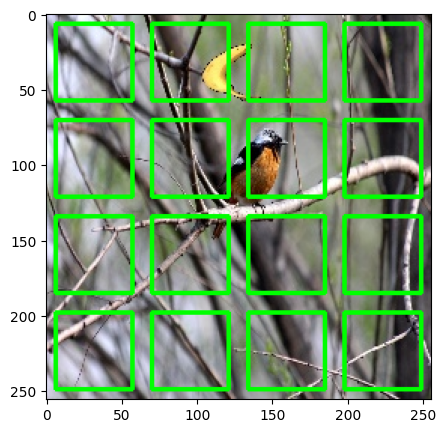

In [15]:
# TEST: test predefined-boxes on feature maps
# img_file = 'images/1.jpg'
img_file = 'TEST_DATASET/bananas_train/images/0.png'
img = tf.io.read_file(img_file)
img = tf.io.decode_image(img, channels=3)
print(img.shape)
h, w = img.shape[:2]
print(h, w)
fmap_w = 4
fmap_h = 4
# fmap_w = 4
# fmap_h = 4
X = tf.random.uniform(shape=(1, 10, fmap_h, fmap_w)) # Construct input data

#TODO: Below code is the best size and ratio for tooth detection
# Y = multibox_prior(X, sizes=[0.15], ratios=[2.5]) # 
Y = multibox_prior(X, sizes=[0.2], ratios=[1.0])
boxes = tf.reshape(Y, [fmap_h, fmap_w, 1,4])
bbox_scale = tf.constant((w, h, w, h), dtype=tf.float32)

print(tf.where(Y < 0))

img_np = img.numpy()
img_copy = img_np.copy()
# Iterate over the bounding boxes and draw them on the same image
for i in range(fmap_w):
    for j in range(fmap_h):
        for _, bbox in enumerate(boxes[i, j,  :, :] * bbox_scale):
            # Draw each bounding box on the same image
            draw_rotated_box(img_copy, bbox, color=(0, 255, 0), thickness=2)
            # draw_rotated_box(img_copy, bbox[1,:], color=(0, 255, 0), thickness=2)
            # draw_rotated_box(img_copy, bbox[2,:], color=(0, 255, 0), thickness=2)
            # draw_rotated_box(img_copy, bbox[3,:], color=(0, 255, 0), thickness=2)


# for _, bbox in enumerate(boxes[5, 10, :, :, :] * bbox_scale):
#             # Draw each bounding box on the same image
#         draw_rotated_box(img_copy, bbox[0,:], color=(0, 255, 0), thickness=2)

# Display the image with all bounding boxes
plt.figure(figsize=(5, 5))
plt.imshow(img_copy)
plt.axis('on')
plt.show()

In [16]:
# DONE : Define oriented IoU(Between for 2 lists of rotated bounding boxes)
from shapely.geometry import Polygon
from math import cos, sin, radians
def rotate_box(box):
    """Calculate the four corners of a rotated box (TensorFlow)."""
    # cx, cy, w, h, angle = box
    cx, cy, w, h = box
    angle = 0


    angle = radians(angle*360) # because angles are normalized between 0 and 1(devided by 360)
    dx = w / 2
    dy = h / 2
    # Calculate the four corners of the rotated rectangle
    corners = np.array([
        [cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)],
        [cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle)]
    ])
    return corners

def polygon_area(corners):
    """Calculate the area of a polygon given its corners."""
    poly = Polygon(corners)
    return poly.area

def polygon_intersection(corners1, corners2):
    """Calculate the intersection area between two polygons."""
    poly1 = Polygon(corners1)
    poly2 = Polygon(corners2)
    inter_area = poly1.intersection(poly2).area
    return inter_area

def box_iou_oriented(boxes1, boxes2):
    """Compute pairwise IoU for rotated bounding boxes (TensorFlow)."""
    batch_size_1 = tf.shape(boxes1)[0]
    batch_size_2 = tf.shape(boxes2)[0]
    
    iou_matrix = np.zeros((batch_size_1, batch_size_2))
    
    for i in range(batch_size_1):
        corners1 = rotate_box(boxes1[i].numpy())
        area1 = polygon_area(corners1)
        
        for j in range(batch_size_2):
            corners2 = rotate_box(boxes2[j].numpy())
            area2 = polygon_area(corners2)
            inter_area = polygon_intersection(corners1, corners2)
            union_area = area1 + area2 - inter_area
            iou_matrix[i, j] = inter_area / union_area if union_area != 0 else 0.0
    
    return tf.convert_to_tensor(iou_matrix, dtype=tf.float32)

#####
# Testing Code 👇👇👇
#####

# Example usage
# boxes1 = tf.convert_to_tensor([
#     [50, 50, 40, 20, 0],  # x_center, y_center, width, height, angle (degrees)
#     [30, 30, 20, 10, 0]
# ], dtype=tf.float32)

# boxes2 = tf.convert_to_tensor([
#     [55, 55, 40, 20, 0],
#     [28, 28, 20, 10, 0]
# ], dtype=tf.float32)

# iou_oriented = box_iou_oriented(boxes1, boxes2)
# print(iou_oriented)

# ******************** Non-oriented IoU👇👇👇👇 ****************** #
###########################
#### Tensorflow version ###
###########################


# def box_iou(boxes1, boxes2):
#   """Compute pairwise IoU across two lists of anchor or bounding boxes."""
#   box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
#   (boxes[:, 3] - boxes[:, 1]))
#   # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
#   # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
#   areas1 = box_area(boxes1)
#   areas2 = box_area(boxes2)
#   # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
#   # boxes1, no. of boxes2, 2)
#   inter_upperlefts = tf.maximum(boxes1[:, None, :2], boxes2[:, :2])
#   inter_lowerrights = tf.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
#   # inters = (inter_lowerrights - inter_upperlefts)
#   # inters = tf.clip_by_value(inters, clip_value_min=0)
#   inters = tf.maximum(inter_lowerrights - inter_upperlefts, 0)
#   # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
#   inter_areas = inters[:, :, 0] * inters[:, :, 1]
#   union_areas = areas1[:, None] + areas2 - inter_areas
#   return inter_areas / union_areas



# # Example usage
# boxes1 = tf.convert_to_tensor([
#     [50, 50, 40, 20],  # x_center, y_center, width, height, angle (degrees)
#     [30, 30, 20, 10]
# ], dtype=tf.float32)

# boxes2 = tf.convert_to_tensor([
#     [55, 55, 40, 20],
#     [28, 28, 20, 10]
# ], dtype=tf.float32)

# boxes1_corner = box_center_to_corner(boxes1)
# print(boxes1_corner)
# boxes2_corner = box_center_to_corner(boxes2)
# print(boxes2_corner)
# iou_oriented = box_iou(boxes1_corner, boxes2_corner)
# print(iou_oriented)

#######################
### PyTorch version ###
#######################

# def box_iou(boxes1, boxes2):
#   """Compute pairwise IoU across two lists of anchor or bounding boxes."""
#   box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
#   (boxes[:, 3] - boxes[:, 1]))
#   # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
#   # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
#   areas1 = box_area(boxes1)
#   areas2 = box_area(boxes2)
#   # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
#   # boxes1, no. of boxes2, 2)
#   inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
#   inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
#   inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
#   # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
#   inter_areas = inters[:, :, 0] * inters[:, :, 1]
#   union_areas = areas1[:, None] + areas2 - inter_areas
#   return inter_areas / union_areas

In [17]:
# DONE: Assign pre-defined anchor boxes to bounding boxes 
def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes in TensorFlow."""
    num_anchors = tf.shape(anchors)[0]
    num_gt_boxes = tf.shape(ground_truth)[0]

    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou_oriented(anchors, ground_truth)

    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = tf.fill([num_anchors], -1)
    anchors_bbox_map = tf.cast(anchors_bbox_map, tf.int64)


    # Assign ground-truth bounding boxes according to the threshold
    max_ious = tf.reduce_max(jaccard, axis=1)
    indices = tf.argmax(jaccard, axis=1)
    
    # Find anchor indices that satisfy the IoU threshold
    anc_i = tf.where(max_ious >= iou_threshold)[:, 0]
    box_j = tf.gather(indices, anc_i)
    


    
    anchors_bbox_map = tf.tensor_scatter_nd_update(anchors_bbox_map, tf.expand_dims(anc_i, 1), box_j)

    # Prepare for discarding columns and rows
    col_discard = tf.fill([num_anchors], -1)
    row_discard = tf.fill([num_gt_boxes], -1)
    # Convert jaccard to numpy array
    jaccard = jaccard.numpy()
    # Convert anchors_bbox_map to numpy array
    anchors_bbox_map = anchors_bbox_map.numpy()  
    for _ in range(num_gt_boxes):
        max_idx = np.argmax(jaccard)  # Find the largest IoU

        box_idx = max_idx % num_gt_boxes
        anc_idx = max_idx // num_gt_boxes


        anchors_bbox_map[anc_idx] = box_idx  # Use .numpy() to convert to numpy array
      
        jaccard[:, box_idx] = col_discard  # Use .numpy() to access box_idx
        jaccard[anc_idx, :] = row_discard  # Use .numpy() to access anc_idx
        # jaccard = tf.convert_to_tensor(jaccard)  # Convert back to tensor

    return anchors_bbox_map

In [18]:
# DONE : Calculate the offsets between anchors and bounding boxes
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors[:,:4]) # Feed the first 4 coordinates to the function(x_min, y_min, x_max, y_max)
    c_assigned_bb = box_corner_to_center(assigned_bb[:,:4])
    # Feed the first 4 coordinates to the function(x_min, y_min, x_max, y_max)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh =  5 * tf.math.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])

    offset = tf.concat([offset_xy, offset_wh], axis=1)

    anchor_angles = anchors[:, -1]
    assigned_angles = assigned_bb[:, -1]
    offset_angle = assigned_angles - anchor_angles
    # print(offset_xy)
    # print(offset_wh)
    # print(offset_angle)
    # offset = tf.concat([offset_xy, offset_wh, tf.expand_dims(offset_angle, axis=1)], axis=1)
    return offset
    

######## Test Code ##########

# Define example anchors and assigned bounding boxes
# anchors = tf.constant([
#     [100, 100, 200, 200],  # Anchor 1
#     [100, 100, 200, 200], # Anchor 2 (rotated by 10 degrees)
#     [100, 100, 200, 200], # Anchor 3 (rotated by 20 degrees)
# ], dtype=tf.float32)

# assigned_bb = tf.constant([
#     [110, 110, 210, 210],  # Ground-truth 1
#     [110, 110, 210, 210], # Ground-truth 2 (rotated by 10 degrees)
#     [110, 110, 210, 210], # Ground-truth 3 (rotated by 20 degrees)
# ], dtype=tf.float32)

# # Calculate offsets
# offsets = offset_boxes(anchors, assigned_bb)
# print("Offsets:\n", offsets)



# ****** Pytorch version ***** #

# def offset_boxes(anchors, assigned_bb, eps=1e-6):
#   """Transform for anchor box offsets."""
#   c_anc = box_corner_to_center(anchors)
#   c_assigned_bb = box_corner_to_center(assigned_bb)
#   offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
#   offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
#   offset = torch.cat([offset_xy, offset_wh], axis=1)
#   return offset

In [19]:
# DONE : Label anchor boxes using ground-truth bounding boxes.

def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], tf.squeeze(anchors, axis=0)
    num_anchors = tf.shape(anchors)[0]
    
    batch_offset = []
    batch_mask = []
    batch_class_labels = []

    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)
        
        bbox_mask = tf.cast(anchors_bbox_map >= 0, tf.float32)
        bbox_mask = tf.expand_dims(bbox_mask, axis=-1)
        # bbox_mask = tf.tile(bbox_mask, [1, 5])
        bbox_mask = tf.tile(bbox_mask, [1, 4])
        
        # Initialize class labels and assigned bounding box coordinates with zeros
        class_labels = tf.zeros(num_anchors, dtype=tf.int64)
        # assigned_bb = tf.zeros((num_anchors, 5), dtype=tf.float32)
        assigned_bb = tf.zeros((num_anchors, 4), dtype=tf.float32)
        
        # Label classes of anchor boxes using their assigned ground-truth bounding boxes
        indices_true = tf.where(anchors_bbox_map >= 0)
        bb_idx = tf.gather_nd(anchors_bbox_map, indices_true)



        class_labels = tf.tensor_scatter_nd_update(class_labels, indices_true, tf.cast(tf.gather(label[:, 0] + 1, bb_idx), tf.int64))
        assigned_bb = tf.tensor_scatter_nd_update(assigned_bb, indices_true, tf.gather(label[:, 1:], bb_idx))

        
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        # print(offset)

        batch_offset.append(tf.reshape(offset, [-1]))
        batch_mask.append(tf.reshape(bbox_mask, [-1]))
        batch_class_labels.append(class_labels)
    
    bbox_offset = tf.stack(batch_offset)
    bbox_mask = tf.stack(batch_mask)
    class_labels = tf.stack(batch_class_labels)
    
    return bbox_offset, bbox_mask, class_labels


# Example



In [20]:
# TEST: This is a testing code for multibox_target function
ground_truth = tf.constant([[0, 0.1, 0.08, 0.52, 0.92],
[1, 0.55, 0.2, 0.9, 0.88]])
anchors = tf.constant([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
[0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
[0.57, 0.3, 0.92, 0.9]])

labels = multibox_target(tf.expand_dims(anchors, axis=0), tf.expand_dims(ground_truth, axis=0))
labels[2]
labels[1]
labels[0]

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
         1.3999999e+00,  9.9999990e+00,  2.5939715e+00,  7.1754241e+00,
        -1.1999989e+00,  2.6881757e-01,  1.6823640e+00, -1.5654519e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -5.7142800e-01, -1.0000001e+00,  4.1723233e-06,  6.2582040e-01]],
      dtype=float32)>

In [21]:
# DONE: Define the loss function
# Define loss functions
cls_loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits  # Equivalent to CrossEntropyLoss
bbox_loss_fn = keras.losses.MeanAbsoluteError(reduction=None)  # Equivalent to L1Loss

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    # Get the batch size and number of classes
    batch_size = tf.shape(cls_preds)[0]
    num_classes = tf.shape(cls_preds)[-1]
    
    # Flatten the class predictions and labels for cross-entropy loss
    cls_preds_flat = tf.reshape(cls_preds, [-1, num_classes])  # Shape: (batch_size * num_anchors, num_classes)
    cls_labels_flat = tf.reshape(cls_labels, [-1])  # Shape: (batch_size * num_anchors,)
    
    # Calculate classification loss
    cls_loss = cls_loss_fn(labels=cls_labels_flat, logits=cls_preds_flat)  # Shape: (batch_size * num_anchors,)
    cls_loss = tf.reshape(cls_loss, [batch_size, -1])  # Shape: (batch_size, num_anchors)
    cls_loss = tf.reduce_mean(cls_loss, axis=1)  # Average over all anchors for each batch

    # Calculate bounding box loss (L1 loss)
    bbox_loss = bbox_loss_fn(bbox_preds * bbox_masks, bbox_labels * bbox_masks)  # Shape: (batch_size, num_anchors, 4)
    # bbox_loss = tf.reduce_mean(bbox_loss, axis=1)  # Average over all anchors for each batch

    # Return the sum of classification and bbox losses
    return cls_loss + bbox_loss

In [22]:
# FIXME

def cls_eval(cls_preds, cls_labels):
    # Argmax along the last dimension to get the predicted classes
    cls_preds_argmax = tf.argmax(cls_preds, axis=-1, output_type=tf.int64)
    
    # Compare with the true labels and count correct predictions
    correct_preds = tf.cast(tf.equal(cls_preds_argmax, cls_labels), tf.float32)
    
    # Sum the correct predictions and return as float
    return tf.reduce_sum(correct_preds)

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    # Calculate the absolute difference between predicted and true bounding boxes,
    # and apply the mask
    bbox_diff = tf.abs(bbox_labels - bbox_preds) * bbox_masks
    
    # Sum the absolute differences and return as float
    return tf.reduce_sum(bbox_diff)

In [23]:
# FIXME: Generate multiple prior boxes for the Auxilary layers of the network

log_dir = './logs'

writer = tf.summary.create_file_writer(log_dir)

learning_rate = 2e-1


optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=5e-4)

# Number of epochs
num_epochs = 20 # Example: 10, 20, 30, 40

num_classes = 1

# ********* Monitoring Configurations ********** #
# Initialize lists to store training and validation losses


# Early stopping parameters
# patience = 5  # Number of epochs to wait for improvement
# min_delta = 1e-3  # Minimum change to qualify as improvement
# best_val_loss = float('inf')
# wait = 0  # Number of epochs without improvement


# Set up the plot

# fig, ax = plt.subplots(figsize=(10, 5))


In [28]:




# for i in range(anchors)

anchors = [None] * 5


for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    train_num_batches = 0
    train_error_cls = 0
    train_error_bbox = 0
    # Loop through the dataset
    for step, (inputs, ground_truth) in enumerate(training_set):
         

        # Open a gradient tape for automatic differentiation
        with tf.GradientTape() as tape:

            cls_preds, bbox_preds, blocks = model(inputs)
            
            for i, block in enumerate(blocks):
                # print(block)
                print(i, block)
                anchors[i] = multibox_prior(tf.transpose(block, perm=[0,3,1,2]), sizes=sizes[i], ratios=ratios[i])


            anchors = tf.concat(anchors, axis=1)
            cls_preds = concat_preds(cls_preds)
            cls_preds = tf.reshape(cls_preds,(cls_preds.shape[0], -1, num_classes + 1))

            bbox_preds = concat_preds(bbox_preds)

            # Label the anchors using ground-truth bounding boxes (multibox_target)
            bbox_offset, bbox_mask, cls_labels = multibox_target(anchors, ground_truth)
            
            
            # Calculate the loss using your custom loss function
            loss = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_offset, bbox_mask)
            loss = tf.reduce_mean(loss)

        
        # Compute all gradients
        gradients = tape.gradient(loss, model.trainable_weights)

        # Apply gradients to update model weights
        optimizer.apply(gradients, model.trainable_weights)

        train_error_cls = 1 - cls_eval(cls_preds, cls_labels) / tf.size(cls_labels, out_type=tf.float32)
        train_error_bbox = bbox_eval(bbox_preds, bbox_offset, bbox_mask) / tf.size(bbox_offset, out_type=tf.float32)
        # epoch_loss += loss
        train_num_batches += 1
        with writer.as_default():
            tf.summary.scalar('loss/CLASS Loss', train_error_cls, step=step)
            tf.summary.scalar('loss/BBOX Loss', train_error_bbox, step=step)
            # tf.summary.scalar('Loss/step', loss, step=(step+1))
        writer.flush() 

        # Print the loss for this step
        print(f"... Step {step + 1}, Step Loss: {loss.numpy()}")
    
    print(f"End of epoch {epoch + 1}\n")

    # Because there are 73 images in the training set and the BATCH_SIZE = 2
    # train_loss = epoch_loss / train_num_batches
    # class_loss = train_error_cls / train_num_batches
    # bbox_loss = train_error_bbox / train_num_batches
    # print(f"Epoch {epoch + 1}, CLASS Loss: {class_loss}")
    # print(f"Epoch {epoch + 1}, BBOX Loss: {bbox_loss}")

    # train_losses.append(train_loss)
    # class_losses.append(class_loss)
    # bbox_losses.append(bbox_loss)
    # Validation loop to calculate validation loss
    # val_loss = 0
    # val_num_batches = 0
    # for val_inputs, val_ground_truth in test_set:  # Using "test set" as validation
    #     # conv_6_out, conv_7_out, conv_8_out, conv_9_out = model(val_inputs)
    #     conv_7_out, conv_8_out = model(val_inputs)
    #     val_loss += calc_loss(cls_preds, cls_labels, bbox_preds, bbox_offset, bbox_mask).numpy()
    #     val_num_batches += 1

    # val_loss /= val_num_batches
    # val_losses.append(val_loss)
    # print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}")

    # # Early stopping check
    # if val_loss < best_val_loss - min_delta:
    #     best_val_loss = val_loss
    #     wait = 0  # Reset wait if improvement
    # else:
    #     wait += 1
    #     if wait >= patience:
    #         print("Early stopping triggered.")
    #         break


    if (epoch + 1) % 2 == 0:
        print("Model Saved ....")
        model.save(f"model_weights/model_epoch_{epoch}.keras")
    



    # Dynamic plotting of training and validation loss
    # ax.clear()  # Only clear the plot in Matplotlib
    # # ax.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='blue')
    # ax.plot(range(1, epoch + 2), bbox_losses, label='BBOX Loss', color='red')
    # ax.plot(range(1, epoch + 2), class_losses, label='CLASS Loss', color='green')
    # # ax.plot(range(1, epoch + 2), val_losses, label='Validation Loss', color='orange')
    # ax.set_xlabel('Epochs')
    # ax.set_ylabel('Loss')
    # ax.set_title('Training and Validation Loss Progress')
    # ax.legend()
    # plt.pause(0.1)  # Pause to update the plot



# plt.show()
# After training
print("Training complete!")




Epoch 1/20
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
0 tf.Tensor(
[[[[ 35.105534    0.        182.88492   ...   0.          0.
     42.945667 ]
   [ 53.43288     0.        184.36092   ...   0.          0.
     85.72053  ]
   [ 54.73113     0.        182.54256   ...   0.          0.
     93.776634 ]
   ...
   [ 58.186855    0.        188.20276   ...   0.          0.
     90.610664 ]
   [ 67.10994     0.        185.70872   ...   0.          0.
     96.733345 ]
   [ 81.26569     0.        157.79031   ...   0.          0.
    129.17548  ]]

  [[  0.          0.        273.94797   ...   0.          0.
      0.       ]
   [  0.          0.        176.01369   ...   0.          0.
      0.       ]
   [  0.          0.        176.48584   ...   0.          0.
      0.       ]
   ...
   [  0.          0.        213.87273   ...   0.          0.
      0.       ]
   [  0.          0.        207.9506

2024-10-31 11:17:06.543814: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [ ]:
# Attention: Code below is not completely tested


In [ ]:
# DONE: Inverse offset function(needs to be checked)

def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets, including angle."""
    # Convert anchor boxes from corner to center format (only first 4 coordinates)
    anc = box_corner_to_center(anchors[:, :4])
    
    # Compute predicted bbox center (xy) coordinates
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    
    # Compute predicted bbox width and height (wh)
    pred_bbox_wh = tf.exp(offset_preds[:, 2:4] / 5) * anc[:, 2:]
    
    # Concatenate predicted xy and wh to form the predicted bbox
    pred_bbox = tf.concat([pred_bbox_xy, pred_bbox_wh], axis=1)
    
    # Convert bbox from center to corner format
    predicted_bbox = box_center_to_corner(pred_bbox)
    
    # Handle the angle component separately
    pred_bbox_angle = offset_preds[:, -1] 
    
    # Concatenate predicted bounding box with predicted angle
    predicted_bbox_with_angle = tf.concat([predicted_bbox, tf.expand_dims(pred_bbox_angle, axis=1)], axis=1)
    
    return predicted_bbox_with_angle

In [ ]:
# TODO: Define NMS function(Not complete)
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes and perform NMS."""
    # Sort scores in descending order
    B = tf.argsort(scores, direction='DESCENDING')
    keep = []  # Indices of predicted bounding boxes that will be kept

    while tf.size(B) > 0:
        i = B[0]  # Index of the highest score
        keep.append(i.numpy())  # Keep this index (convert to numpy to append to list)

        if tf.size(B) == 1:
            break  # Only one element left, stop

        # Gather the selected box and remaining boxes
        selected_box = tf.gather(boxes, i)  # Tensor shape (5,)
        remaining_boxes = tf.gather(boxes, B[1:])  # Tensor shape (N-1, 5)

        # Calculate IoU between the selected box and remaining boxes
        iou = box_iou_oriented(tf.reshape(selected_box, (1, 5)), remaining_boxes)
        iou = tf.reshape(iou, (-1,))

        # Find indices where IoU is less than or equal to threshold
        inds = tf.where(iou <= iou_threshold)
        inds = tf.reshape(inds, (-1,))

        # Update B to keep only boxes with IoU less than or equal to the threshold
        B = tf.gather(B, inds + 1)
    
    return tf.convert_to_tensor(keep)

In [ ]:
# def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
# pos_threshold=0.009999999):
#   """Predict bounding boxes using non-maximum suppression."""
#   device, batch_size = cls_probs.device, cls_probs.shape[0]
#   anchors = anchors.squeeze(0)
#   num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
#   out = []
#   for i in range(batch_size):
#     cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
#     conf, class_id = torch.max(cls_prob[1:], 0)
#     predicted_bb = offset_inverse(anchors, offset_pred)
#     keep = nms(predicted_bb, conf, nms_threshold)
#     # Find all non-`keep` indices and set the class to background
#     all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
#     combined = torch.cat((keep, all_idx))
#     uniques, counts = combined.unique(return_counts=True)
#     non_keep = uniques[counts == 1]
#     all_id_sorted = torch.cat((keep, non_keep))
#     class_id[non_keep] = -1
#     class_id = class_id[all_id_sorted]
#     conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
#     # Here `pos_threshold` is a threshold for positive (non-background)
#     # predictions
#     below_min_idx = (conf < pos_threshold)
#     class_id[below_min_idx] = -1
#     conf[below_min_idx] = 1 - conf[below_min_idx]
#     pred_info = torch.cat((class_id.unsqueeze(1),conf.unsqueeze(1),predicted_bb), dim=1)
#     out.append(pred_info)
#   return torch.stack(out)

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    batch_size = cls_probs.shape[0]
    anchors = tf.squeeze(anchors, axis=0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    
    for i in range(batch_size):
        cls_prob = cls_probs[i]
        offset_pred = tf.reshape(offset_preds[i], (-1, 5))
        
        # Get maximum class confidence and class ID for each anchor
        conf = tf.reduce_max(cls_prob[1:], axis=0)
        class_id = tf.argmax(cls_prob[1:], axis=0, output_type=tf.int32)
        
        # Decode predicted bounding boxes
        predicted_bb = offset_inverse(anchors, offset_pred)  # Assuming `offset_inverse` is defined
        
        # Apply Non-Maximum Suppression
        keep = nms(predicted_bb, conf, nms_threshold)  # Assuming `nms` is defined
        
        # Find all non-`keep` indices and set the class to background
        all_idx = tf.range(num_anchors, dtype=tf.int32)
        non_keep_sparse = tf.sets.difference([all_idx], [keep])
        non_keep = tf.sparse.to_dense(non_keep_sparse)[0]  # Convert SparseTensor to dense
        
        # Rearrange indices
        all_id_sorted = tf.concat([keep, non_keep], axis=0)
        class_id = tf.tensor_scatter_nd_update(class_id, tf.expand_dims(non_keep, 1), tf.fill(tf.shape(non_keep), -1))
        class_id = tf.gather(class_id, all_id_sorted)
        conf = tf.gather(conf, all_id_sorted)
        predicted_bb = tf.gather(predicted_bb, all_id_sorted)
        
        # Set low-confidence predictions to background
        below_min_idx = tf.where(conf < pos_threshold)
        class_id = tf.tensor_scatter_nd_update(class_id, below_min_idx, tf.fill(tf.shape(below_min_idx)[:1], -1))
        conf = tf.tensor_scatter_nd_update(conf, below_min_idx, 1 - tf.gather_nd(conf, below_min_idx))
        
        # Combine results
        pred_info = tf.concat([tf.expand_dims(tf.cast(class_id, tf.float32), 1), 
                               tf.expand_dims(conf, 1), 
                               predicted_bb], axis=1)
        
        out.append(pred_info)
    
    return tf.stack(out)


In [ ]:
loaded_model = keras.saving.load_model("model_weights/model_epoch_19.keras")

img_file = 'TEST_DATASET/bananas_test/2.png'
img = tf.io.read_file(img_file)
img = tf.io.decode_image(img, channels=3)
# print(img)
img = tf.cast(img, tf.int32)  # Convert to integer type (equivalent to `.long()` in PyTorch)
X = tf.expand_dims(img, axis=0)
print(X.shape)
X = tf.transpose(X, perm=[0, 3, 1, 2])  # Remove the first dimension and permute
print(X.shape)

In [ ]:


X = tf.transpose(X, perm=[0, 2, 3, 1])
anchors = anchors

def predict(X):
  cls_preds = []
  bbox_preds = []
  # net.eval()
  # print(X.shape)
  class_predictions, bbox_predictions = model(X)
  cls_preds.append(class_predictions)

  bbox_preds.append(bbox_predictions)
  cls_preds = concat_preds(cls_preds)
  cls_preds = tf.reshape(cls_preds,(cls_preds.shape[0], -1, num_classes + 1))
  bbox_preds = concat_preds(bbox_preds)
  print(X.shape)
  
  # cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
  cls_probs = tf.nn.softmax(cls_preds, axis=-1)  # Softmax along the last dimension (axis=-1)
  # cls_probs = tf.transpose(cls_probs, perm=[0, 3, 1, 2])  # Permute dimensions from (batch_size, num_anchors, num_classes)
  output = multibox_detection(cls_probs, bbox_preds, anchors)
  idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
  idx = tf.convert_to_tensor(idx, dtype=tf.int32)
    
  # Use tf.gather to get the rows corresponding to idx
  filtered_output = tf.gather(output[0], idx)
    
  return filtered_output


output = predict(X)

In [ ]:
print(output)

In [ ]:
# def display(img, output, threshold):
#   plt.rcParams['figure.figsize'] = (5,5)
#   fig = plt.imshow(img)
#   for row in output:
#     score = float(row[1])
#     if score < threshold:
#       continue
#     h, w = img.shape[:2]
#     bbox = [row[2:6] * tf.constant((w, h, w, h), dtype=float)]
#     show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
# display(img, output.cpu(), threshold=0.9)

for row in output:
    score = float(row[1])
    if score < 0.9:
      continue
    h, w = img.shape[:2]
    bbox = row[2:7] * tf.constant((w, h, w, h, 1), dtype=tf.float32)

    draw_rotated_box(img.numpy(), bbox, color=(0, 255, 0), thickness=2)


# Display the image with all bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(img.numpy())
plt.axis('off')
plt.show()